# Project: Predicting Stock Price & Return  
## 3. Feature Creation and Random Forest Classifier
Data source include: Alphavantage free API, Bank of Canada, Google Trends

Ver 2.0  
Add the second way of feature engineering: 20d return in 2 levels  
Ver 1.0  
Remove unecessary content  
Ver 0.4  
Change the target to return-level (discrete value) and use RandomForestClassifier. Get the feature importance chart  
Ver 0.3  
Try to filter the outliers   
Ver 0.2  
Use loblaws price only to construct features and try linear regression, random forest regression, and neuro networks  
Ver 0.1  
Explore the features, plot the histgram and correlations

#### 0.Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import talib

In [2]:
#let the notebook display full length of the data columns
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

#### 1. Create target

In [3]:
df = pd.read_csv("data_transformed.csv", parse_dates=['date'], index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4356 entries, 2003-01-02 to 2019-10-18
Data columns (total 21 columns):
loblaw_price           4356 non-null float64
loblaw_volume          4356 non-null float64
metro_price            4356 non-null float64
metro_volume           4356 non-null float64
empa_price             4356 non-null float64
empa_volume            4356 non-null float64
gwl_price              4356 non-null float64
gwl_volume             4356 non-null float64
atd_price              4356 non-null float64
atd_volume             4356 non-null float64
tsx_price              4356 non-null float64
tsx_volume             4356 non-null float64
sp500_price            4356 non-null float64
sp500_volume           4356 non-null float64
BCPI                   4356 non-null float64
CPI                    4356 non-null float64
bank_interest          4356 non-null float64
CEER                   4356 non-null float64
trend_grocery_store    4104 non-null float64
trend_loblaws       

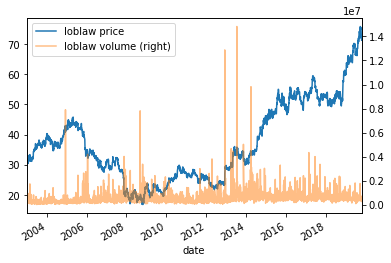

In [4]:
df['loblaw_price'].plot(label = 'loblaw price', legend = True)
df['loblaw_volume'].plot(secondary_y=True, alpha=0.5, label = 'loblaw volume' , legend = True)
plt.show()

In [5]:
df['loblaw_5d_future'] = df['loblaw_price'].shift(-5)
df['loblaw_5d_future_pct'] = df['loblaw_5d_future'].pct_change(5)
df['loblaws_5d_return_level'] = pd.qcut(df['loblaw_5d_future_pct'], 5, labels=False)


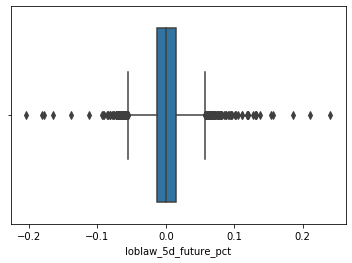

In [6]:
sns.boxplot(df['loblaw_5d_future_pct'])
plt.show()

In [7]:
df['loblaw_5d_future_pct'].quantile(0.2),df['loblaw_5d_future_pct'].quantile(0.4), df['loblaw_5d_future_pct'].quantile(0.6), df['loblaw_5d_future_pct'].quantile(0.8)

(-0.017069046097713536,
 -0.00443925510603238,
 0.005166295198320903,
 0.019545255291413044)

In [8]:
df.loblaws_5d_return_level.value_counts()

0.0    871
4.0    870
3.0    870
2.0    870
1.0    870
Name: loblaws_5d_return_level, dtype: int64

#### 2. Create features

In [9]:
feature_names = []
stock_list = ['loblaw', 'metro', 'gwl', 'empa', 'atd', 'tsx', 'sp500']
for stock in stock_list:
    for n in [14, 30, 50, 200]:
        df[stock + '_ma' + str(n)] = talib.SMA(df['loblaw_price'].values, timeperiod=n) / df['loblaw_price']
        df[stock + '_rsi' + str(n)] = talib.RSI(df['loblaw_price'].values, timeperiod=n) 
        feature_names = feature_names + [stock + '_ma' + str(n), stock + '_rsi' + str(n)]
    
    df[stock + '_5d_pct'] = df[stock + '_price'].pct_change(5)
    feature_names = feature_names + [stock + '_5d_pct']
    feature_names = feature_names + [stock + '_price']

    df[stock + '_volume_1d_pct_SMA'] = talib.SMA(df[stock + '_volume'].pct_change().values, timeperiod=5)
    feature_names = feature_names + [stock + '_volume_1d_pct_SMA']


In [10]:
df.dropna(inplace=True)

In [11]:
df.shape

(4099, 94)

In [12]:
df.head()

,loblaw_price,loblaw_volume,metro_price,metro_volume,empa_price,empa_volume,gwl_price,gwl_volume,atd_price,atd_volume,tsx_price,tsx_volume,sp500_price,sp500_volume,BCPI,CPI,bank_interest,CEER,trend_grocery_store,trend_loblaws,trend_stock,loblaw_5d_future,loblaw_5d_future_pct,loblaws_5d_return_level,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_5d_pct,loblaw_volume_1d_pct_SMA,metro_ma14,metro_rsi14,metro_ma30,metro_rsi30,metro_ma50,metro_rsi50,metro_ma200,metro_rsi200,metro_5d_pct,metro_volume_1d_pct_SMA,gwl_ma14,gwl_rsi14,gwl_ma30,gwl_rsi30,gwl_ma50,gwl_rsi50,gwl_ma200,gwl_rsi200,gwl_5d_pct,gwl_volume_1d_pct_SMA,empa_ma14,empa_rsi14,empa_ma30,empa_rsi30,empa_ma50,empa_rsi50,empa_ma200,empa_rsi200,empa_5d_pct,empa_volume_1d_pct_SMA,atd_ma14,atd_rsi14,atd_ma30,atd_rsi30,atd_ma50,atd_rsi50,atd_ma200,atd_rsi200,atd_5d_pct,atd_volume_1d_pct_SMA,tsx_ma14,tsx_rsi14,tsx_ma30,tsx_rsi30,tsx_ma50,tsx_rsi50,tsx_ma200,tsx_rsi200,tsx_5d_pct,tsx_volume_1d_pct_SMA,sp500_ma14,sp500_rsi14,sp500_ma30,sp500_rsi30,sp500_ma50,sp500_rsi50,sp500_ma200,sp500_rsi200,sp500_5d_pct,sp500_volume_1d_pct_SMA
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-02,40.1113,138500.0,4.0356,1534500.0,4.9414,23640.0,76.2923,39200.0,1.3143,248988.0,8293.7002,51827800.0,1108.48,1.153200e+09,359.414,103.314286,4.5,113.27,46.857143,26.928571,16.952381,39.4905,-0.015477,1.0,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.033511,0.180955,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.025722,1.908547,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.037302,0.192458,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.025868,1.229243,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.040370,1.162818,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.019082,-0.023063,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.011368,0.117906
2004-01-05,39.9635,151800.0,3.9620,171600.0,4.8872,23703.0,74.9241,40500.0,1.3257,6178356.0,8381.7002,133797400.0,1122.22,1.578200e+09,362.716,103.328571,4.5,113.83,46.714286,26.857143,16.904762,39.7979,-0.004144,2.0,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.026577,0.344122,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.004666,1.831072,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.014705,0.266762,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.013101,0.408344,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.064990,5.961248,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.030098,0.400297,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.025758,0.301147
2004-01-06,39.8748,372500.0,4.0467,2180700.0,4.8330,265395.0,74.5477,52700.0,1.2986,3894228.0,8405.0996,190509700.0,1123.67,1.494500e+09,366.018,103.342857,4.5,113.53,46.571429,26.785714,16.857143,39.3132,-0.014084,1.0,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.012002,0.564555,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.014312,4.166331,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,-0.000776,0.399414,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,-0.001879,2.626745,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.045993,5.977770,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.017505,0.398238,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.012790,0.081784
2004-01-07,40.3182,196400.0,4.0560,438000.0,4.8421,62139.0,74.9604,120100.0,1.3094,4084548.0,8388.5000,238648300.0,

In [13]:
df.tail()

,loblaw_price,loblaw_volume,metro_price,metro_volume,empa_price,empa_volume,gwl_price,gwl_volume,atd_price,atd_volume,tsx_price,tsx_volume,sp500_price,sp500_volume,BCPI,CPI,bank_interest,CEER,trend_grocery_store,trend_loblaws,trend_stock,loblaw_5d_future,loblaw_5d_future_pct,loblaws_5d_return_level,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_5d_pct,loblaw_volume_1d_pct_SMA,metro_ma14,metro_rsi14,metro_ma30,metro_rsi30,metro_ma50,metro_rsi50,metro_ma200,metro_rsi200,metro_5d_pct,metro_volume_1d_pct_SMA,gwl_ma14,gwl_rsi14,gwl_ma30,gwl_rsi30,gwl_ma50,gwl_rsi50,gwl_ma200,gwl_rsi200,gwl_5d_pct,gwl_volume_1d_pct_SMA,empa_ma14,empa_rsi14,empa_ma30,empa_rsi30,empa_ma50,empa_rsi50,empa_ma200,empa_rsi200,empa_5d_pct,empa_volume_1d_pct_SMA,atd_ma14,atd_rsi14,atd_ma30,atd_rsi30,atd_ma50,atd_rsi50,atd_ma200,atd_rsi200,atd_5d_pct,atd_volume_1d_pct_SMA,tsx_ma14,tsx_rsi14,tsx_ma30,tsx_rsi30,tsx_ma50,tsx_rsi50,tsx_ma200,tsx_rsi200,tsx_5d_pct,tsx_volume_1d_pct_SMA,sp500_ma14,sp500_rsi14,sp500_ma30,sp500_rsi30,sp500_ma50,sp500_rsi50,sp500_ma200,sp500_rsi200,sp500_5d_pct,sp500_volume_1d_pct_SMA
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-07,75.11,317700.0,58.15,568100.0,36.8151,367664.0,111.50,216800.0,40.38,1136853.0,16421.8008,155833300.0,2938.7900,2.940140e+09,432.33,136.8,3.95,117.16,80.0,34.0,64.0,72.805,-0.030688,0.0,0.996595,61.415627,0.981414,62.134346,0.960199,61.173941,0.895543,57.865880,-0.004638,-0.054802,0.996595,61.415627,0.981414,62.134346,0.960199,61.173941,0.895543,57.865880,-0.003086,0.075352,0.996595,61.415627,0.981414,62.134346,0.960199,61.173941,0.895543,57.865880,0.000359,0.011330,0.996595,61.415627,0.981414,62.134346,0.960199,61.173941,0.895543,57.865880,0.029830,0.211733,0.996595,61.415627,0.981414,62.134346,0.960199,61.173941,0.895543,57.865880,-0.005419,0.132042,0.996595,61.415627,0.981414,62.134346,0.960199,61.173941,0.895543,57.865880,-0.014215,-0.039740,0.996595,61.415627,0.981414,62.134346,0.960199,61.173941,0.895543,57.865880,-0.012749,-0.014521
2019-10-08,74.03,546600.0,57.69,598900.0,36.3368,441693.0,110.57,239800.0,40.03,2054431.0,16294.0000,198432200.0,2893.0601,3.356450e+09,432.33,136.8,3.95,117.08,80.0,34.0,64.0,72.600,-0.019316,0.0,1.011945,51.644687,0.996961,57.259734,0.975908,58.174314,0.909560,57.078367,-0.010426,0.110588,1.011945,51.644687,0.996961,57.259734,0.975908,58.174314,0.909560,57.078367,0.001041,-0.014994,1.011945,51.644687,0.996961,57.259734,0.975908,58.174314,0.909560,57.078367,-0.000181,0.022396,1.011945,51.644687,0.996961,57.259734,0.975908,58.174314,0.909560,57.078367,0.011375,0.265096,1.011945,51.644687,0.996961,57.259734,0.975908,58.174314,0.909560,57.078367,-0.003733,0.304940,1.011945,51.644687,0.996961,57.259734,0.975908,58.174314,0.909560,57.078367,-0.009345,-0.009375,1.011945,51.644687,0.996961,57.259734,0.975908,58.174314,0.909560,57.078367,-0.016050,-0.005319
2019-10-09,74.15,659800.0,57.74,467000.0,35.9580,433538.0,111.50,184200.0,40.88,2100359.0,16379.9004,168389300.0,2919.3999,2.726820e+09,432.33,136.8,3.95,117.03,80.0,34.0,64.0,71.620,-0.034120,0.0,1.011155,52.548033,0.996535,57.641703,0.975841,58.405556,0.909057,57.143498,-0.009749,0.178590,1.011155,52.548033,0.996535,57.641703,0.975841,58.405556,0.909057,57.143498,-0.005340,-0.026848,1.011155,52.548033,0.996535,57.641703,0.975841,58.405556,0.909057,57.143498,0.006954,0.006814,1.011155,52.548033,0.996535,57.641703,0.975841,58.405556,0.909057,57.143498,-0.004964,0.278526,1.011155,52.548033,0.996535,57.641703,0.975841,58.405556,0.909057,57.143498,0.011881,0.367570,1.011155,52.548033,0.996535,57.641703,0.975841,58.405556,0.909057,57.143498,0.004224,-0.033442,1.011155,52.548033,0.996535,57.641703,0.975841,58.405556,0.909057,57.143498,0.011009,-0.062762
2019-10-10,73.43,591200.0,57.20,471700.0,35.3800,865449.0,110.96,114500.0,40.10,1739158.0,16422.6992,186014600.0,2938.1299,3.217250e+09,432.33,136.8,3.95,117

In [14]:
economic_indices = ['BCPI', 'CPI', 'bank_interest', 'CEER']
google_trends = ['trend_grocery_store', 'trend_loblaws', 'trend_stock']
feature_names = feature_names + economic_indices + google_trends
print(feature_names)

['loblaw_ma14', 'loblaw_rsi14', 'loblaw_ma30', 'loblaw_rsi30', 'loblaw_ma50', 'loblaw_rsi50', 'loblaw_ma200', 'loblaw_rsi200', 'loblaw_5d_pct', 'loblaw_price', 'loblaw_volume_1d_pct_SMA', 'metro_ma14', 'metro_rsi14', 'metro_ma30', 'metro_rsi30', 'metro_ma50', 'metro_rsi50', 'metro_ma200', 'metro_rsi200', 'metro_5d_pct', 'metro_price', 'metro_volume_1d_pct_SMA', 'gwl_ma14', 'gwl_rsi14', 'gwl_ma30', 'gwl_rsi30', 'gwl_ma50', 'gwl_rsi50', 'gwl_ma200', 'gwl_rsi200', 'gwl_5d_pct', 'gwl_price', 'gwl_volume_1d_pct_SMA', 'empa_ma14', 'empa_rsi14', 'empa_ma30', 'empa_rsi30', 'empa_ma50', 'empa_rsi50', 'empa_ma200', 'empa_rsi200', 'empa_5d_pct', 'empa_price', 'empa_volume_1d_pct_SMA', 'atd_ma14', 'atd_rsi14', 'atd_ma30', 'atd_rsi30', 'atd_ma50', 'atd_rsi50', 'atd_ma200', 'atd_rsi200', 'atd_5d_pct', 'atd_price', 'atd_volume_1d_pct_SMA', 'tsx_ma14', 'tsx_rsi14', 'tsx_ma30', 'tsx_rsi30', 'tsx_ma50', 'tsx_rsi50', 'tsx_ma200', 'tsx_rsi200', 'tsx_5d_pct', 'tsx_price', 'tsx_volume_1d_pct_SMA', 'sp500_ma

In [15]:
features = df[feature_names]
targets = df[['loblaws_5d_return_level']].values.ravel()

#### 3. Create train and test set

In [16]:
train_size = int(0.75 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

In [17]:
print(train_features.shape, train_targets.shape)
print(test_features.shape, test_targets.shape)

(3074, 84) (3074,)
(1025, 84) (1025,)


#### 4. Model training

In [18]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

In [19]:
grid = {'n_estimators':[200], 'max_depth': [3,5,7], 'max_features': [4,8,16,32,64], 'random_state': [42]}
test_scores = []
rfc = RandomForestClassifier()

for g in ParameterGrid(grid):
    rfc.set_params(**g)  
    rfc.fit(train_features, train_targets)
    test_scores.append(rfc.score(test_features, test_targets))

best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.1902439024390244 {'random_state': 42, 'n_estimators': 200, 'max_features': 64, 'max_depth': 3}


In [20]:
rfc= RandomForestClassifier(n_estimators=200, max_features=64, max_depth=3, random_state=42)
rfc.fit(train_features, train_targets)
print(rfc.score(train_features, train_targets))
print(rfc.score(test_features, test_targets))

predicts = rfc.predict(test_features)

0.36629798308392975
0.1902439024390244


#### 5. Model evaluation

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [22]:
accuracy_score(test_targets, predicts)

0.1902439024390244

In [23]:
cm = confusion_matrix(test_targets, predicts)

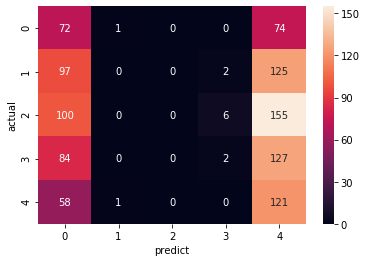

In [24]:
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel('predict')
plt.ylabel('actual')
plt.show()

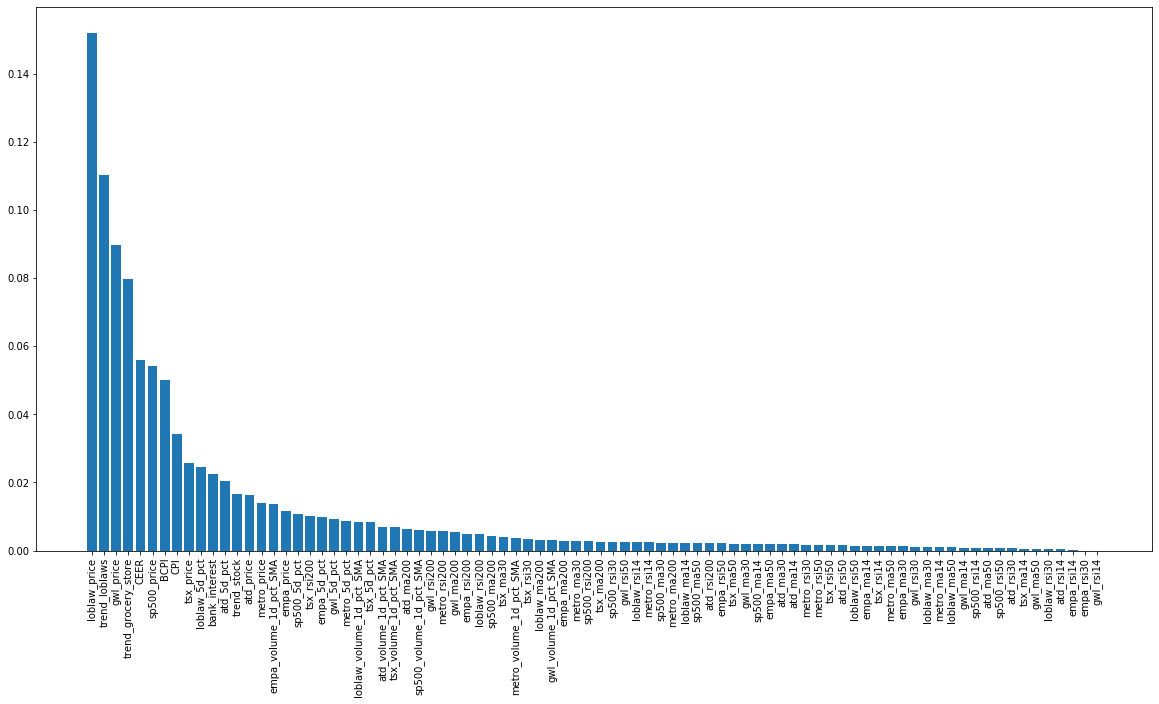

In [25]:
# Get feature importances from our random forest model
importances = rfc.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.figure(figsize=(20,10))
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

#### 6. Try the second way of creating targets

In [26]:
df = pd.read_csv("data_transformed.csv", parse_dates=['date'], index_col='date')

In [27]:
df['loblaw_5d_future'] = df['loblaw_price'].shift(-5)
df['loblaw_5d_future_pct'] = df['loblaw_5d_future'].pct_change(5)

In [28]:
Q1 = df['loblaw_5d_future_pct'].quantile(0.25)
Q3 = df['loblaw_5d_future_pct'].quantile(0.75)
IQR = Q3 - Q1

df['loblaws_5d_return_level'] = df['loblaw_5d_future_pct'].apply(lambda x: 0 if x < (Q1 - 1.5 * IQR) 
                                                                else 1 if (Q1 - 1.5 * IQR) < x < Q1
                                                                else 2  if Q1 < x < Q3
                                                                else 3  if Q3 < x < (Q3 + 1.5 * IQR) 
                                                                else 4)

In [29]:
df['loblaws_5d_return_level'].value_counts()

2    2175
1    1013
3    992 
4    101 
0    75  
Name: loblaws_5d_return_level, dtype: int64

In [30]:
feature_names = []
stock_list = ['loblaw', 'metro', 'gwl', 'empa', 'atd', 'tsx', 'sp500']
for stock in stock_list:
    for n in [14, 30, 50, 200]:
        df[stock + '_ma' + str(n)] = talib.SMA(df['loblaw_price'].values, timeperiod=n) / df['loblaw_price']
        df[stock + '_rsi' + str(n)] = talib.RSI(df['loblaw_price'].values, timeperiod=n) 
        feature_names = feature_names + [stock + '_ma' + str(n), stock + '_rsi' + str(n)]
    
    df[stock + '_5d_pct'] = df[stock + '_price'].pct_change(5)
    feature_names = feature_names + [stock + '_5d_pct']
    feature_names = feature_names + [stock + '_price']

    df[stock + '_volume_1d_pct_SMA'] = talib.SMA(df[stock + '_volume'].pct_change().values, timeperiod=5)
    feature_names = feature_names + [stock + '_volume_1d_pct_SMA']

In [31]:
df.dropna(inplace=True)

In [32]:
df.shape

(4099, 94)

In [33]:
df.head()

,loblaw_price,loblaw_volume,metro_price,metro_volume,empa_price,empa_volume,gwl_price,gwl_volume,atd_price,atd_volume,tsx_price,tsx_volume,sp500_price,sp500_volume,BCPI,CPI,bank_interest,CEER,trend_grocery_store,trend_loblaws,trend_stock,loblaw_5d_future,loblaw_5d_future_pct,loblaws_5d_return_level,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_5d_pct,loblaw_volume_1d_pct_SMA,metro_ma14,metro_rsi14,metro_ma30,metro_rsi30,metro_ma50,metro_rsi50,metro_ma200,metro_rsi200,metro_5d_pct,metro_volume_1d_pct_SMA,gwl_ma14,gwl_rsi14,gwl_ma30,gwl_rsi30,gwl_ma50,gwl_rsi50,gwl_ma200,gwl_rsi200,gwl_5d_pct,gwl_volume_1d_pct_SMA,empa_ma14,empa_rsi14,empa_ma30,empa_rsi30,empa_ma50,empa_rsi50,empa_ma200,empa_rsi200,empa_5d_pct,empa_volume_1d_pct_SMA,atd_ma14,atd_rsi14,atd_ma30,atd_rsi30,atd_ma50,atd_rsi50,atd_ma200,atd_rsi200,atd_5d_pct,atd_volume_1d_pct_SMA,tsx_ma14,tsx_rsi14,tsx_ma30,tsx_rsi30,tsx_ma50,tsx_rsi50,tsx_ma200,tsx_rsi200,tsx_5d_pct,tsx_volume_1d_pct_SMA,sp500_ma14,sp500_rsi14,sp500_ma30,sp500_rsi30,sp500_ma50,sp500_rsi50,sp500_ma200,sp500_rsi200,sp500_5d_pct,sp500_volume_1d_pct_SMA
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-02,40.1113,138500.0,4.0356,1534500.0,4.9414,23640.0,76.2923,39200.0,1.3143,248988.0,8293.7002,51827800.0,1108.48,1.153200e+09,359.414,103.314286,4.5,113.27,46.857143,26.928571,16.952381,39.4905,-0.015477,1,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.033511,0.180955,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.025722,1.908547,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.037302,0.192458,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.025868,1.229243,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.040370,1.162818,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.019082,-0.023063,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.011368,0.117906
2004-01-05,39.9635,151800.0,3.9620,171600.0,4.8872,23703.0,74.9241,40500.0,1.3257,6178356.0,8381.7002,133797400.0,1122.22,1.578200e+09,362.716,103.328571,4.5,113.83,46.714286,26.857143,16.904762,39.7979,-0.004144,2,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.026577,0.344122,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.004666,1.831072,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.014705,0.266762,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.013101,0.408344,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.064990,5.961248,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.030098,0.400297,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.025758,0.301147
2004-01-06,39.8748,372500.0,4.0467,2180700.0,4.8330,265395.0,74.5477,52700.0,1.2986,3894228.0,8405.0996,190509700.0,1123.67,1.494500e+09,366.018,103.342857,4.5,113.53,46.571429,26.785714,16.857143,39.3132,-0.014084,1,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.012002,0.564555,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.014312,4.166331,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,-0.000776,0.399414,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,-0.001879,2.626745,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.045993,5.977770,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.017505,0.398238,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.012790,0.081784
2004-01-07,40.3182,196400.0,4.0560,438000.0,4.8421,62139.0,74.9604,120100.0,1.3094,4084548.0,8388.5000,238648300.0,1126.3

In [34]:
df.tail()

,loblaw_price,loblaw_volume,metro_price,metro_volume,empa_price,empa_volume,gwl_price,gwl_volume,atd_price,atd_volume,tsx_price,tsx_volume,sp500_price,sp500_volume,BCPI,CPI,bank_interest,CEER,trend_grocery_store,trend_loblaws,trend_stock,loblaw_5d_future,loblaw_5d_future_pct,loblaws_5d_return_level,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_5d_pct,loblaw_volume_1d_pct_SMA,metro_ma14,metro_rsi14,metro_ma30,metro_rsi30,metro_ma50,metro_rsi50,metro_ma200,metro_rsi200,metro_5d_pct,metro_volume_1d_pct_SMA,gwl_ma14,gwl_rsi14,gwl_ma30,gwl_rsi30,gwl_ma50,gwl_rsi50,gwl_ma200,gwl_rsi200,gwl_5d_pct,gwl_volume_1d_pct_SMA,empa_ma14,empa_rsi14,empa_ma30,empa_rsi30,empa_ma50,empa_rsi50,empa_ma200,empa_rsi200,empa_5d_pct,empa_volume_1d_pct_SMA,atd_ma14,atd_rsi14,atd_ma30,atd_rsi30,atd_ma50,atd_rsi50,atd_ma200,atd_rsi200,atd_5d_pct,atd_volume_1d_pct_SMA,tsx_ma14,tsx_rsi14,tsx_ma30,tsx_rsi30,tsx_ma50,tsx_rsi50,tsx_ma200,tsx_rsi200,tsx_5d_pct,tsx_volume_1d_pct_SMA,sp500_ma14,sp500_rsi14,sp500_ma30,sp500_rsi30,sp500_ma50,sp500_rsi50,sp500_ma200,sp500_rsi200,sp500_5d_pct,sp500_volume_1d_pct_SMA
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-07,75.11,317700.0,58.15,568100.0,36.8151,367664.0,111.50,216800.0,40.38,1136853.0,16421.8008,155833300.0,2938.7900,2.940140e+09,432.33,136.8,3.95,117.16,80.0,34.0,64.0,72.805,-0.030688,1,0.996595,61.415627,0.981414,62.134346,0.960199,61.173941,0.895543,57.865880,-0.004638,-0.054802,0.996595,61.415627,0.981414,62.134346,0.960199,61.173941,0.895543,57.865880,-0.003086,0.075352,0.996595,61.415627,0.981414,62.134346,0.960199,61.173941,0.895543,57.865880,0.000359,0.011330,0.996595,61.415627,0.981414,62.134346,0.960199,61.173941,0.895543,57.865880,0.029830,0.211733,0.996595,61.415627,0.981414,62.134346,0.960199,61.173941,0.895543,57.865880,-0.005419,0.132042,0.996595,61.415627,0.981414,62.134346,0.960199,61.173941,0.895543,57.865880,-0.014215,-0.039740,0.996595,61.415627,0.981414,62.134346,0.960199,61.173941,0.895543,57.865880,-0.012749,-0.014521
2019-10-08,74.03,546600.0,57.69,598900.0,36.3368,441693.0,110.57,239800.0,40.03,2054431.0,16294.0000,198432200.0,2893.0601,3.356450e+09,432.33,136.8,3.95,117.08,80.0,34.0,64.0,72.600,-0.019316,1,1.011945,51.644687,0.996961,57.259734,0.975908,58.174314,0.909560,57.078367,-0.010426,0.110588,1.011945,51.644687,0.996961,57.259734,0.975908,58.174314,0.909560,57.078367,0.001041,-0.014994,1.011945,51.644687,0.996961,57.259734,0.975908,58.174314,0.909560,57.078367,-0.000181,0.022396,1.011945,51.644687,0.996961,57.259734,0.975908,58.174314,0.909560,57.078367,0.011375,0.265096,1.011945,51.644687,0.996961,57.259734,0.975908,58.174314,0.909560,57.078367,-0.003733,0.304940,1.011945,51.644687,0.996961,57.259734,0.975908,58.174314,0.909560,57.078367,-0.009345,-0.009375,1.011945,51.644687,0.996961,57.259734,0.975908,58.174314,0.909560,57.078367,-0.016050,-0.005319
2019-10-09,74.15,659800.0,57.74,467000.0,35.9580,433538.0,111.50,184200.0,40.88,2100359.0,16379.9004,168389300.0,2919.3999,2.726820e+09,432.33,136.8,3.95,117.03,80.0,34.0,64.0,71.620,-0.034120,1,1.011155,52.548033,0.996535,57.641703,0.975841,58.405556,0.909057,57.143498,-0.009749,0.178590,1.011155,52.548033,0.996535,57.641703,0.975841,58.405556,0.909057,57.143498,-0.005340,-0.026848,1.011155,52.548033,0.996535,57.641703,0.975841,58.405556,0.909057,57.143498,0.006954,0.006814,1.011155,52.548033,0.996535,57.641703,0.975841,58.405556,0.909057,57.143498,-0.004964,0.278526,1.011155,52.548033,0.996535,57.641703,0.975841,58.405556,0.909057,57.143498,0.011881,0.367570,1.011155,52.548033,0.996535,57.641703,0.975841,58.405556,0.909057,57.143498,0.004224,-0.033442,1.011155,52.548033,0.996535,57.641703,0.975841,58.405556,0.909057,57.143498,0.011009,-0.062762
2019-10-10,73.43,591200.0,57.20,471700.0,35.3800,865449.0,110.96,114500.0,40.10,1739158.0,16422.6992,186014600.0,2938.1299,3.217250e+09,432.33,136.8,3.95,117.15,80

In [35]:
economic_indices = ['BCPI', 'CPI', 'bank_interest', 'CEER']
google_trends = ['trend_grocery_store', 'trend_loblaws', 'trend_stock']
feature_names = feature_names + economic_indices + google_trends
print(feature_names)

['loblaw_ma14', 'loblaw_rsi14', 'loblaw_ma30', 'loblaw_rsi30', 'loblaw_ma50', 'loblaw_rsi50', 'loblaw_ma200', 'loblaw_rsi200', 'loblaw_5d_pct', 'loblaw_price', 'loblaw_volume_1d_pct_SMA', 'metro_ma14', 'metro_rsi14', 'metro_ma30', 'metro_rsi30', 'metro_ma50', 'metro_rsi50', 'metro_ma200', 'metro_rsi200', 'metro_5d_pct', 'metro_price', 'metro_volume_1d_pct_SMA', 'gwl_ma14', 'gwl_rsi14', 'gwl_ma30', 'gwl_rsi30', 'gwl_ma50', 'gwl_rsi50', 'gwl_ma200', 'gwl_rsi200', 'gwl_5d_pct', 'gwl_price', 'gwl_volume_1d_pct_SMA', 'empa_ma14', 'empa_rsi14', 'empa_ma30', 'empa_rsi30', 'empa_ma50', 'empa_rsi50', 'empa_ma200', 'empa_rsi200', 'empa_5d_pct', 'empa_price', 'empa_volume_1d_pct_SMA', 'atd_ma14', 'atd_rsi14', 'atd_ma30', 'atd_rsi30', 'atd_ma50', 'atd_rsi50', 'atd_ma200', 'atd_rsi200', 'atd_5d_pct', 'atd_price', 'atd_volume_1d_pct_SMA', 'tsx_ma14', 'tsx_rsi14', 'tsx_ma30', 'tsx_rsi30', 'tsx_ma50', 'tsx_rsi50', 'tsx_ma200', 'tsx_rsi200', 'tsx_5d_pct', 'tsx_price', 'tsx_volume_1d_pct_SMA', 'sp500_ma

In [36]:
features = df[feature_names]
targets = df[['loblaws_5d_return_level']].values.ravel()

In [37]:
train_size = int(0.75 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

In [38]:
print(train_features.shape, train_targets.shape)
print(test_features.shape, test_targets.shape)

(3074, 84) (3074,)
(1025, 84) (1025,)


In [39]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

In [40]:
grid = {'n_estimators':[200], 'max_depth': [3,5,7], 'max_features': [4,8,16,32,64], 'random_state': [42]}
test_scores = []
rfc = RandomForestClassifier()

for g in ParameterGrid(grid):
    rfc.set_params(**g)  
    rfc.fit(train_features, train_targets)
    test_scores.append(rfc.score(test_features, test_targets))

best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.5795121951219512 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


In [41]:
rfc= RandomForestClassifier(n_estimators=200, max_features=4, max_depth=3, random_state=42)
rfc.fit(train_features, train_targets)
print(rfc.score(train_features, train_targets))
print(rfc.score(test_features, test_targets))

predicts = rfc.predict(test_features)

0.4808067664281067
0.5795121951219512


In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [43]:
cm = confusion_matrix(test_targets, predicts)

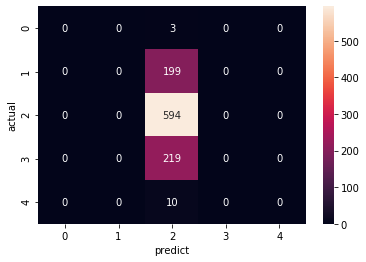

In [44]:
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel('predict')
plt.ylabel('actual')
plt.show()

#### 7. Try the third way of creating targets

In [93]:
df = pd.read_csv("data_transformed.csv", parse_dates=['date'], index_col='date')

In [94]:
df['loblaw_20d_future'] = df['loblaw_price'].shift(-20)
df['loblaw_20d_future_pct'] = df['loblaw_20d_future'].pct_change(20)
df['loblaws_20d_return_level'] = pd.qcut(df['loblaw_20d_future_pct'], 2, labels=False)

In [95]:
df['loblaw_20d_future_pct'].quantile(0.5)

0.002565134984581996

In [96]:
df['loblaws_20d_return_level'].value_counts()

0.0    2168
1.0    2168
Name: loblaws_20d_return_level, dtype: int64

In [97]:
feature_names = []
stock_list = ['loblaw', 'metro', 'gwl', 'empa', 'atd', 'tsx', 'sp500']
for stock in stock_list:
    for n in [14, 30, 50, 200]:
        df[stock + '_ma' + str(n)] = talib.SMA(df['loblaw_price'].values, timeperiod=n) / df['loblaw_price']
        df[stock + '_rsi' + str(n)] = talib.RSI(df['loblaw_price'].values, timeperiod=n) 
        feature_names = feature_names + [stock + '_ma' + str(n), stock + '_rsi' + str(n)]
    
    df[stock + '_5d_pct'] = df[stock + '_price'].pct_change(5)
    feature_names = feature_names + [stock + '_5d_pct']
    feature_names = feature_names + [stock + '_price']

    df[stock + '_volume_1d_pct_SMA'] = talib.SMA(df[stock + '_volume'].pct_change().values, timeperiod=5)
    feature_names = feature_names + [stock + '_volume_1d_pct_SMA']

In [98]:
df.dropna(inplace=True)

In [99]:
df.shape

(4084, 94)

In [100]:
df.head()

,loblaw_price,loblaw_volume,metro_price,metro_volume,empa_price,empa_volume,gwl_price,gwl_volume,atd_price,atd_volume,tsx_price,tsx_volume,sp500_price,sp500_volume,BCPI,CPI,bank_interest,CEER,trend_grocery_store,trend_loblaws,trend_stock,loblaw_20d_future,loblaw_20d_future_pct,loblaws_20d_return_level,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_5d_pct,loblaw_volume_1d_pct_SMA,metro_ma14,metro_rsi14,metro_ma30,metro_rsi30,metro_ma50,metro_rsi50,metro_ma200,metro_rsi200,metro_5d_pct,metro_volume_1d_pct_SMA,gwl_ma14,gwl_rsi14,gwl_ma30,gwl_rsi30,gwl_ma50,gwl_rsi50,gwl_ma200,gwl_rsi200,gwl_5d_pct,gwl_volume_1d_pct_SMA,empa_ma14,empa_rsi14,empa_ma30,empa_rsi30,empa_ma50,empa_rsi50,empa_ma200,empa_rsi200,empa_5d_pct,empa_volume_1d_pct_SMA,atd_ma14,atd_rsi14,atd_ma30,atd_rsi30,atd_ma50,atd_rsi50,atd_ma200,atd_rsi200,atd_5d_pct,atd_volume_1d_pct_SMA,tsx_ma14,tsx_rsi14,tsx_ma30,tsx_rsi30,tsx_ma50,tsx_rsi50,tsx_ma200,tsx_rsi200,tsx_5d_pct,tsx_volume_1d_pct_SMA,sp500_ma14,sp500_rsi14,sp500_ma30,sp500_rsi30,sp500_ma50,sp500_rsi50,sp500_ma200,sp500_rsi200,sp500_5d_pct,sp500_volume_1d_pct_SMA
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-02,40.1113,138500.0,4.0356,1534500.0,4.9414,23640.0,76.2923,39200.0,1.3143,248988.0,8293.7002,51827800.0,1108.48,1.153200e+09,359.414,103.314286,4.5,113.27,46.857143,26.928571,16.952381,39.3900,-0.017982,0.0,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.033511,0.180955,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.025722,1.908547,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.037302,0.192458,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.025868,1.229243,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.040370,1.162818,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.019082,-0.023063,0.960816,77.290248,0.934630,66.815338,0.934426,62.018971,0.893032,56.860472,0.011368,0.117906
2004-01-05,39.9635,151800.0,3.9620,171600.0,4.8872,23703.0,74.9241,40500.0,1.3257,6178356.0,8381.7002,133797400.0,1122.22,1.578200e+09,362.716,103.328571,4.5,113.83,46.714286,26.857143,16.904762,38.8698,-0.027367,0.0,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.026577,0.344122,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.004666,1.831072,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.014705,0.266762,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.013101,0.408344,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.064990,5.961248,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.030098,0.400297,0.969812,74.319163,0.940774,65.568829,0.939214,61.311976,0.897338,56.699252,0.025758,0.301147
2004-01-06,39.8748,372500.0,4.0467,2180700.0,4.8330,265395.0,74.5477,52700.0,1.2986,3894228.0,8405.0996,190509700.0,1123.67,1.494500e+09,366.018,103.342857,4.5,113.53,46.571429,26.785714,16.857143,39.1654,-0.017791,0.0,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.012002,0.564555,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.014312,4.166331,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,-0.000776,0.399414,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,-0.001879,2.626745,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.045993,5.977770,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.017505,0.398238,0.976946,72.517526,0.945422,64.818091,0.942549,60.886927,0.900352,56.602454,0.012790,0.081784
2004-01-07,40.3182,196400.0,4.0560,438000.0,4.8421,62139.0,74.9604,120100.0,1.3094,4084548.0,8388.5000,238648300

In [101]:
df.tail()

,loblaw_price,loblaw_volume,metro_price,metro_volume,empa_price,empa_volume,gwl_price,gwl_volume,atd_price,atd_volume,tsx_price,tsx_volume,sp500_price,sp500_volume,BCPI,CPI,bank_interest,CEER,trend_grocery_store,trend_loblaws,trend_stock,loblaw_20d_future,loblaw_20d_future_pct,loblaws_20d_return_level,loblaw_ma14,loblaw_rsi14,loblaw_ma30,loblaw_rsi30,loblaw_ma50,loblaw_rsi50,loblaw_ma200,loblaw_rsi200,loblaw_5d_pct,loblaw_volume_1d_pct_SMA,metro_ma14,metro_rsi14,metro_ma30,metro_rsi30,metro_ma50,metro_rsi50,metro_ma200,metro_rsi200,metro_5d_pct,metro_volume_1d_pct_SMA,gwl_ma14,gwl_rsi14,gwl_ma30,gwl_rsi30,gwl_ma50,gwl_rsi50,gwl_ma200,gwl_rsi200,gwl_5d_pct,gwl_volume_1d_pct_SMA,empa_ma14,empa_rsi14,empa_ma30,empa_rsi30,empa_ma50,empa_rsi50,empa_ma200,empa_rsi200,empa_5d_pct,empa_volume_1d_pct_SMA,atd_ma14,atd_rsi14,atd_ma30,atd_rsi30,atd_ma50,atd_rsi50,atd_ma200,atd_rsi200,atd_5d_pct,atd_volume_1d_pct_SMA,tsx_ma14,tsx_rsi14,tsx_ma30,tsx_rsi30,tsx_ma50,tsx_rsi50,tsx_ma200,tsx_rsi200,tsx_5d_pct,tsx_volume_1d_pct_SMA,sp500_ma14,sp500_rsi14,sp500_ma30,sp500_rsi30,sp500_ma50,sp500_rsi50,sp500_ma200,sp500_rsi200,sp500_5d_pct,sp500_volume_1d_pct_SMA
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-16,71.92,582400.0,56.22,717900.0,35.2006,380974.0,108.86,157600.0,39.990,3106722.0,16751.3008,307592600.0,2997.9600,4.274640e+09,431.276,136.8,3.95,117.36,85.116279,34.767442,66.558140,72.805,0.012305,1.0,1.012982,51.894780,0.994036,56.976135,0.969763,57.465805,0.920223,56.533348,-0.030427,0.122236,1.012982,51.894780,0.994036,56.976135,0.969763,57.465805,0.920223,56.533348,-0.029016,0.027718,1.012982,51.894780,0.994036,56.976135,0.969763,57.465805,0.920223,56.533348,-0.017246,0.040111,1.012982,51.894780,0.994036,56.976135,0.969763,57.465805,0.920223,56.533348,-0.044630,0.071651,1.012982,51.894780,0.994036,56.976135,0.969763,57.465805,0.920223,56.533348,-0.073647,0.237127,1.012982,51.894780,0.994036,56.976135,0.969763,57.465805,0.920223,56.533348,0.015532,0.091198,1.012982,51.894780,0.994036,56.976135,0.969763,57.465805,0.920223,56.533348,0.006557,0.019908
2019-09-17,72.21,528500.0,57.15,452100.0,35.6591,429435.0,110.71,242000.0,40.485,3278148.0,16834.8008,247102000.0,3005.7000,3.671840e+09,432.168,136.8,3.95,117.29,84.651163,34.697674,66.325581,72.600,0.005401,1.0,1.009608,54.283172,0.991752,57.978858,0.967383,58.068624,0.917310,56.696570,-0.019144,0.070585,1.009608,54.283172,0.991752,57.978858,0.967383,58.068624,0.917310,56.696570,-0.004355,-0.068994,1.009608,54.283172,0.991752,57.978858,0.967383,58.068624,0.917310,56.696570,0.002698,0.103971,1.009608,54.283172,0.991752,57.978858,0.967383,58.068624,0.917310,56.696570,-0.012965,-0.025549,1.009608,54.283172,0.991752,57.978858,0.967383,58.068624,0.917310,56.696570,-0.062504,0.254188,1.009608,54.283172,0.991752,57.978858,0.967383,58.068624,0.917310,56.696570,0.017990,0.031984,1.009608,54.283172,0.991752,57.978858,0.967383,58.068624,0.917310,56.696570,0.008831,-0.027676
2019-09-18,73.19,721600.0,57.00,770400.0,35.6890,400800.0,111.36,242400.0,40.535,2640686.0,16800.3008,232114900.0,3006.7300,3.435540e+09,433.060,136.8,3.95,117.13,84.186047,34.627907,66.093023,71.620,-0.021451,0.0,0.996904,61.279458,0.980585,61.144592,0.956266,60.022369,0.905935,57.241883,0.011820,-0.010043,0.996904,61.279458,0.980585,61.144592,0.956266,60.022369,0.905935,57.241883,-0.007833,0.128257,0.996904,61.279458,0.980585,61.144592,0.956266,60.022369,0.905935,57.241883,0.014069,0.106850,0.996904,61.279458,0.980585,61.144592,0.956266,60.022369,0.905935,57.241883,-0.001670,-0.024915,0.996904,61.279458,0.980585,61.144592,0.956266,60.022369,0.905935,57.241883,-0.055568,0.272118,0.996904,61.279458,0.980585,61.144592,0.956266,60.022369,0.905935,57.241883,0.011390,0.036418,0.996904,61.279458,0.980585,61.144592,0.956266,60.022369,0.905935,57.241883,0.001933,-0.019447
2019-09-19,73.27,621000.0,57.16,532200.0,35.8683,302097.0,111.24,137800.0,41.490,2359004.0,16858.4004,2093259

In [102]:
economic_indices = ['BCPI', 'CPI', 'bank_interest', 'CEER']
google_trends = ['trend_grocery_store', 'trend_loblaws', 'trend_stock']
feature_names = feature_names + economic_indices + google_trends
print(feature_names)

['loblaw_ma14', 'loblaw_rsi14', 'loblaw_ma30', 'loblaw_rsi30', 'loblaw_ma50', 'loblaw_rsi50', 'loblaw_ma200', 'loblaw_rsi200', 'loblaw_5d_pct', 'loblaw_price', 'loblaw_volume_1d_pct_SMA', 'metro_ma14', 'metro_rsi14', 'metro_ma30', 'metro_rsi30', 'metro_ma50', 'metro_rsi50', 'metro_ma200', 'metro_rsi200', 'metro_5d_pct', 'metro_price', 'metro_volume_1d_pct_SMA', 'gwl_ma14', 'gwl_rsi14', 'gwl_ma30', 'gwl_rsi30', 'gwl_ma50', 'gwl_rsi50', 'gwl_ma200', 'gwl_rsi200', 'gwl_5d_pct', 'gwl_price', 'gwl_volume_1d_pct_SMA', 'empa_ma14', 'empa_rsi14', 'empa_ma30', 'empa_rsi30', 'empa_ma50', 'empa_rsi50', 'empa_ma200', 'empa_rsi200', 'empa_5d_pct', 'empa_price', 'empa_volume_1d_pct_SMA', 'atd_ma14', 'atd_rsi14', 'atd_ma30', 'atd_rsi30', 'atd_ma50', 'atd_rsi50', 'atd_ma200', 'atd_rsi200', 'atd_5d_pct', 'atd_price', 'atd_volume_1d_pct_SMA', 'tsx_ma14', 'tsx_rsi14', 'tsx_ma30', 'tsx_rsi30', 'tsx_ma50', 'tsx_rsi50', 'tsx_ma200', 'tsx_rsi200', 'tsx_5d_pct', 'tsx_price', 'tsx_volume_1d_pct_SMA', 'sp500_ma

In [103]:
features = df[feature_names]
targets = df[['loblaws_20d_return_level']].values.ravel()

In [104]:
train_size = int(0.75 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]

In [105]:
print(train_features.shape, train_targets.shape)
print(test_features.shape, test_targets.shape)

(3063, 84) (3063,)
(1021, 84) (1021,)


In [106]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

In [107]:
grid = {'n_estimators':[200], 'max_depth': [3,5,7], 'max_features': [4,8,16,32,64], 'random_state': [42]}
test_scores = []
rfc = RandomForestClassifier()

for g in ParameterGrid(grid):
    rfc.set_params(**g)  
    rfc.fit(train_features, train_targets)
    test_scores.append(rfc.score(test_features, test_targets))

best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.5788442703232125 {'random_state': 42, 'n_estimators': 200, 'max_features': 8, 'max_depth': 7}


In [108]:
rfc= RandomForestClassifier(n_estimators=200, max_features=8, max_depth=7, random_state=42)
rfc.fit(train_features, train_targets)
print(rfc.score(train_features, train_targets))
print(rfc.score(test_features, test_targets))

predicts = rfc.predict(test_features)

0.921645445641528
0.5788442703232125


In [109]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

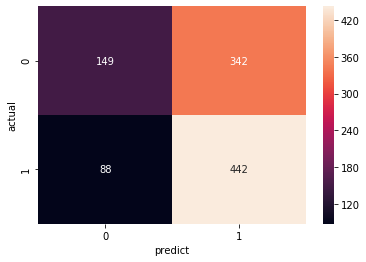

In [111]:
sns.heatmap(cm,annot=True,fmt="d")
plt.xlabel('predict')
plt.ylabel('actual')
plt.show()

In [89]:
cm.sum(axis=1)

array([507, 518])

In [90]:
cm.sum(axis=0)

array([165, 860])

In [91]:
cm

array([[ 80, 427],
       [ 85, 433]])

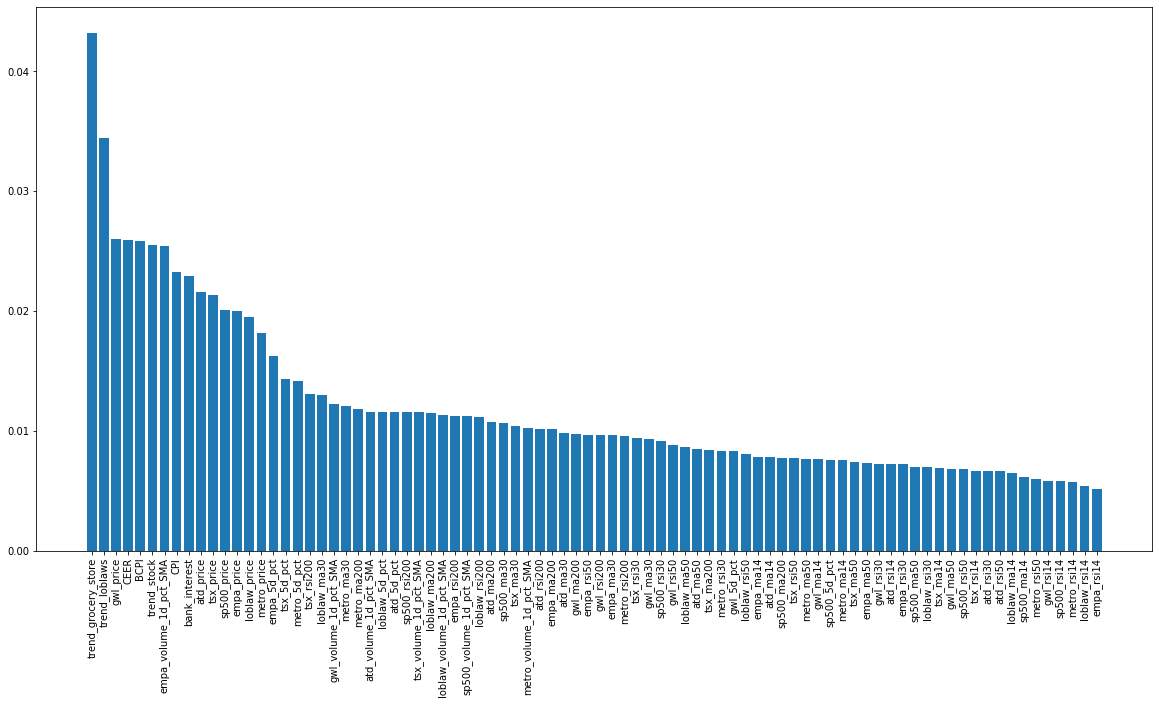

In [92]:
# Get feature importances from our random forest model
importances = rfc.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.figure(figsize=(20,10))
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

In [68]:
df.to_csv("data_feature_created.csv")

In [69]:
labels

array(['trend_grocery_store', 'trend_loblaws', 'gwl_price', 'CPI',
       'atd_price', 'BCPI', 'loblaw_price', 'metro_price', 'empa_price',
       'tsx_price', 'sp500_price', 'trend_stock', 'CEER', 'loblaw_rsi200',
       'gwl_rsi200', 'tsx_rsi200', 'atd_rsi200', 'sp500_rsi200',
       'metro_rsi200', 'bank_interest', 'empa_rsi200', 'metro_ma200',
       'empa_ma200', 'tsx_ma200', 'sp500_ma200', 'gwl_ma200',
       'loblaw_ma50', 'atd_ma50', 'empa_ma50', 'tsx_ma30', 'atd_ma200',
       'tsx_ma50', 'sp500_ma30', 'loblaw_ma200', 'loblaw_ma30',
       'metro_ma50', 'gwl_ma14', 'gwl_ma30', 'metro_ma30', 'gwl_ma50',
       'atd_ma14', 'empa_ma30', 'tsx_ma14', 'metro_rsi50', 'loblaw_rsi50',
       'atd_ma30', 'empa_rsi50', 'atd_rsi50', 'sp500_rsi50', 'sp500_ma50',
       'empa_ma14', 'gwl_rsi50', 'tsx_rsi50', 'loblaw_ma14',
       'loblaw_5d_pct', 'loblaw_volume_1d_pct_SMA', 'metro_ma14',
       'sp500_ma14', 'tsx_5d_pct', 'empa_rsi30', 'gwl_rsi30',
       'empa_volume_1d_pct_SMA', 'empa_rsi